# Connecting the notebook

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# importation

In [2]:
import itertools
import os
import random
import six
import numpy as np
import cv2
import glob
import random
import numpy as np
from tqdm import tqdm
from time import time
from PIL import Image
from keras.models import *
from keras.layers import *
import matplotlib.pyplot as plt
import json
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import glob
import sys

In [3]:
try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence
try:
    from tqdm import tqdm
except ImportError:
    print("tqdm not found, disabling progress bars")

def tqdm(iter):
    return iter

## Taking care of reproducibility 

In [4]:
import tensorflow as tf
from tensorflow import random as tr
seed_value=1254
os.environ['PYTHONHASHSEEN']='0'
random.seed(seed_value)
np.random.seed(seed_value)
tr.set_seed(1234)
#confihgure a new global tensorflow session 


# Necessary functions 

In [5]:
IMAGE_ORDERING_CHANNELS_LAST = "channels_last"
IMAGE_ORDERING_CHANNELS_FIRST = "channels_first"
IMAGE_ORDERING = IMAGE_ORDERING_CHANNELS_LAST

#### Moving to the locals files 

In [6]:
import sys
pathg = '/content/drive/My Drive/mobilenet/'
sys.path.append(pathg)
from keras_segmentation.models.mobilenet import get_mobilenet_encoder

# Model

In [7]:
if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

In [8]:
def get_segmentation_model(input, output):
    img_input = input
    o = output
    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape
    
    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height*output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((output_height*output_width, -1)))(o)

    o = (Activation('sigmoid'))(o) 
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    return model


In [9]:
check_dir='/content/drive/My Drive/mobilenet/checkpoints/'
model_checkpoint = ModelCheckpoint(check_dir+'/delineation.h5', save_weights_only=False,verbose=True)

In [10]:
def masked_categorical_crossentropy(gt, pr):
    from keras.losses import categorical_crossentropy
    mask = 1 - gt[:, :, 0]
    return categorical_crossentropy(gt, pr) * mask

In [11]:

def find_latest_checkpoint(checkpoints_path, fail_safe=True):

    # This is legacy code, there should always be a "checkpoint" file in your directory

    def get_epoch_number_from_path(path):
        return path.replace(checkpoints_path, "").strip(".")

    # Get all matching files
    all_checkpoint_files = glob.glob(checkpoints_path + ".*")
    if len(all_checkpoint_files) == 0:
        all_checkpoint_files = glob.glob(checkpoints_path + "*.*")
    all_checkpoint_files = [ff.replace(".h5", "") for ff in
                            all_checkpoint_files]  # to make it work for newer versions of keras
    # Filter out entries where the epoc_number part is pure number
    all_checkpoint_files = list(filter(lambda f: get_epoch_number_from_path(f)
                                       .isdigit(), all_checkpoint_files))
    if not len(all_checkpoint_files):
        # The glob list is empty, don't have a checkpoints_path
        if not fail_safe:
            raise ValueError("Checkpoint path {0} invalid"
                             .format(checkpoints_path))
        else:
            return None

    # Find the checkpoint file with the maximum epoch
    latest_epoch_checkpoint = max(all_checkpoint_files,
                                  key=lambda f:
                                  int(get_epoch_number_from_path(f)))

    return latest_epoch_checkpoint

# class_colors = [(random.randint(0, 255), random.randint(
#     0, 255), random.randint(0, 255)) for _ in range(5000)]

class_colors = [(random.randint(0, 1), random.randint(
    0, 1)) for _ in range(2)]

class_colors

[(1, 0), (1, 1)]

## Predict function

In [12]:
#augmentation 

import numpy as np

try:
    import imgaug as ia
    from imgaug import augmenters as iaa
except ImportError:
    print("Error in loading augmentation, can't import imgaug."
          "Please make sure it is installed.")

IMAGE_AUGMENTATION_SEQUENCE = None
IMAGE_AUGMENTATION_NUM_TRIES = 10

loaded_augmentation_name = ""

def _load_augmentation_aug_geometric():
    return iaa.OneOf([
        iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.2)]),
        iaa.CropAndPad(percent=(-0.05, 0.1),
                       pad_mode='constant',
                       pad_cval=(0, 255)),
        iaa.Crop(percent=(0.0, 0.1)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Sequential([
            iaa.Affine(
                    # scale images to 80-120% of their size,
                    # individually per axis
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-45, 45),  # rotate by -45 to +45 degrees
                    shear=(-16, 16),  # shear by -16 to +16 degrees
                    # use nearest neighbour or bilinear interpolation (fast)
                    order=[0, 1],
                    # if mode is constant, use a cval between 0 and 255
                    mode='constant',
                    cval=(0, 255),
                    # use any of scikit-image's warping modes
                    # (see 2nd image from the top for examples)
            ),
            iaa.Sometimes(0.3, iaa.Crop(percent=(0.3, 0.5)))])
    ])


def _load_augmentation_aug_non_geometric():
    return iaa.Sequential([
        iaa.Sometimes(0.3, iaa.Multiply((0.5, 1.5), per_channel=0.5)),
        iaa.Sometimes(0.2, iaa.JpegCompression(compression=(70, 99))),
        iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Sometimes(0.2, iaa.MotionBlur(k=15, angle=[-45, 45])),
        iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
        iaa.Sometimes(0.2, iaa.MultiplySaturation((0.5, 1.5))),
        iaa.Sometimes(0.34, iaa.MultiplyHueAndSaturation((0.5, 1.5),
                                                         per_channel=True)),
        iaa.Sometimes(0.34, iaa.Grayscale(alpha=(0.0, 1.0))),
        iaa.Sometimes(0.2, iaa.ChangeColorTemperature((1100, 10000))),
        iaa.Sometimes(0.1, iaa.GammaContrast((0.5, 2.0))),
        iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10),
                                               cutoff=(0.4, 0.6))),
        iaa.Sometimes(0.1, iaa.CLAHE()),
        iaa.Sometimes(0.1, iaa.HistogramEqualization()),
        iaa.Sometimes(0.2, iaa.LinearContrast((0.5, 2.0), per_channel=0.5)),
        iaa.Sometimes(0.1, iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)))
    ])


def _load_augmentation_aug_all2():
    return iaa.Sequential([
        iaa.Sometimes(0.65, _load_augmentation_aug_non_geometric()),
        iaa.Sometimes(0.65, _load_augmentation_aug_geometric())
    ])


def _load_augmentation_aug_all():
    """ Load image augmentation model """

    def sometimes(aug):
        return iaa.Sometimes(0.5, aug)

    return iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.2),  # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode='constant',
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                # scale images to 80-120% of their size, individually per axis
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # translate by -20 to +20 percent (per axis)
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),  # rotate by -45 to +45 degrees
                shear=(-16, 16),  # shear by -16 to +16 degrees
                # use nearest neighbour or bilinear interpolation (fast)
                order=[0, 1],
                # if mode is constant, use a cval between 0 and 255
                cval=(0, 255),
                # use any of scikit-image's warping modes
                # (see 2nd image from the top for examples)
                mode='constant'
            )),
            # execute 0 to 5 of the following (less important) augmenters per
            # image don't execute all of them, as that would often be way too
            # strong
            iaa.SomeOf((0, 5),
                       [
                # convert images into their superpixel representation
                sometimes(iaa.Superpixels(
                    p_replace=(0, 1.0), n_segments=(20, 200))),
                iaa.OneOf([
                    # blur images with a sigma between 0 and 3.0
                    iaa.GaussianBlur((0, 3.0)),
                    # blur image using local means with kernel sizes
                    # between 2 and 7
                    iaa.AverageBlur(k=(2, 7)),
                    # blur image using local medians with kernel sizes
                    # between 2 and 7
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(
                            0.75, 1.5)),  # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(
                    0, 2.0)),  # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.BlendAlphaSimplexNoise(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                # add gaussian noise to images
                iaa.AdditiveGaussianNoise(loc=0, scale=(
                    0.0, 0.05*255), per_channel=0.5),
                iaa.OneOf([
                    # randomly remove up to 10% of the pixels
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(
                        0.02, 0.05), per_channel=0.2),
                ]),
                # invert color channels
                iaa.Invert(0.05, per_channel=True),
                # change brightness of images (by -10 to 10 of original value)
                iaa.Add((-10, 10), per_channel=0.5),
                # change hue and saturation
                iaa.AddToHueAndSaturation((-20, 20)),
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply(
                                (0.5, 1.5), per_channel=0.5),
                    iaa.BlendAlphaFrequencyNoise(
                        exponent=(-4, 0),
                        foreground=iaa.Multiply(
                            (0.5, 1.5), per_channel=True),
                        background=iaa.contrast.LinearContrast(
                            (0.5, 2.0))
                    )
                ]),
                # improve or worsen the contrast
                iaa.contrast.LinearContrast((0.5, 2.0), per_channel=0.5),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                # move pixels locally around (with random strengths)
                sometimes(iaa.ElasticTransformation(
                    alpha=(0.5, 3.5), sigma=0.25)),
                # sometimes move parts of the image around
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
                random_order=True
            )
        ],
        random_order=True
    )


augmentation_functions = {
    "aug_all": _load_augmentation_aug_all,
    "aug_all2": _load_augmentation_aug_all2,
    "aug_geometric": _load_augmentation_aug_geometric,
    "aug_non_geometric": _load_augmentation_aug_non_geometric
}


def _load_augmentation(augmentation_name="aug_all"):

    global IMAGE_AUGMENTATION_SEQUENCE

    if augmentation_name not in augmentation_functions:
        raise ValueError("Augmentation name not supported")

    IMAGE_AUGMENTATION_SEQUENCE = augmentation_functions[augmentation_name]()


def _augment_seg(img, seg, augmentation_name="aug_all", other_imgs=None):

    global loaded_augmentation_name

    if (not IMAGE_AUGMENTATION_SEQUENCE) or\
       (augmentation_name != loaded_augmentation_name):
        _load_augmentation(augmentation_name)
        loaded_augmentation_name = augmentation_name

    # Create a deterministic augmentation from the random one
    aug_det = IMAGE_AUGMENTATION_SEQUENCE.to_deterministic()
    # Augment the input image
    image_aug = aug_det.augment_image(img)

    if other_imgs is not None:
        image_aug = [image_aug]

        for other_img in other_imgs:
            image_aug.append(aug_det.augment_image(other_img))

    segmap = ia.SegmentationMapsOnImage(
        seg, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr()
    return image_aug, segmap_aug


def _custom_augment_seg(img, seg, augmentation_function, other_imgs=None):
    augmentation_functions['custom_aug'] = augmentation_function

    return _augment_seg(img, seg, "custom_aug", other_imgs=other_imgs)


def _try_n_times(fn, n, *args, **kargs):
    """ Try a function N times """
    attempts = 0
    while attempts < n:
        try:
            return fn(*args, **kargs)
        except Exception:
            attempts += 1

    return fn(*args, **kargs)


def augment_seg(img, seg, augmentation_name="aug_all", other_imgs=None):
    return _try_n_times(_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES,
                        img, seg, augmentation_name=augmentation_name,
                        other_imgs=other_imgs)


def custom_augment_seg(img, seg, augmentation_function, other_imgs=None):
    return _try_n_times(_custom_augment_seg, IMAGE_AUGMENTATION_NUM_TRIES,
                        img, seg, augmentation_function=augmentation_function,
                        other_imgs=other_imgs)


ACCEPTABLE_IMAGE_FORMATS = [".jpg", ".jpeg", ".png", ".bmp"]
ACCEPTABLE_SEGMENTATION_FORMATS = [".png", ".bmp"]


class DataLoaderError(Exception):
    pass

def get_image_list_from_path(images_path ):
    image_files = []
    for dir_entry in os.listdir(images_path):
            if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                    os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                file_name, file_extension = os.path.splitext(dir_entry)
                image_files.append(os.path.join(images_path, dir_entry))
    return image_files


def get_pairs_from_paths(images_path, segs_path, ignore_non_matching=False, other_inputs_paths=None):
    """ Find all the images from the images_path directory and
        the segmentation images from the segs_path directory
        while checking integrity of data """

    image_files = []
    segmentation_files = {}

    for dir_entry in os.listdir(images_path):
        if os.path.isfile(os.path.join(images_path, dir_entry)) and \
                os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            image_files.append((file_name, file_extension,
                                os.path.join(images_path, dir_entry)))

    if other_inputs_paths is not None:
        other_inputs_files = []

        for i, other_inputs_path in enumerate(other_inputs_paths):
            temp = []

            for y, dir_entry in enumerate(os.listdir(other_inputs_path)):
                if os.path.isfile(os.path.join(other_inputs_path, dir_entry)) and \
                        os.path.splitext(dir_entry)[1] in ACCEPTABLE_IMAGE_FORMATS:
                    file_name, file_extension = os.path.splitext(dir_entry)

                    temp.append((file_name, file_extension,
                                 os.path.join(other_inputs_path, dir_entry)))

            other_inputs_files.append(temp)

    for dir_entry in os.listdir(segs_path):
        if os.path.isfile(os.path.join(segs_path, dir_entry)) and \
           os.path.splitext(dir_entry)[1] in ACCEPTABLE_SEGMENTATION_FORMATS:
            file_name, file_extension = os.path.splitext(dir_entry)
            full_dir_entry = os.path.join(segs_path, dir_entry)
            if file_name in segmentation_files:
                raise DataLoaderError("Segmentation file with filename {0}"
                                      " already exists and is ambiguous to"
                                      " resolve with path {1}."
                                      " Please remove or rename the latter."
                                      .format(file_name, full_dir_entry))

            segmentation_files[file_name] = (file_extension, full_dir_entry)

    return_value = []
    # Match the images and segmentations
    for image_file, _, image_full_path in image_files:
        if image_file in segmentation_files:
            if other_inputs_paths is not None:
                other_inputs = []
                for file_paths in other_inputs_files:
                    success = False

                    for (other_file, _, other_full_path) in file_paths:
                        if image_file == other_file:
                            other_inputs.append(other_full_path)
                            success = True
                            break

                    if not success:
                        raise ValueError("There was no matching other input to", image_file, "in directory")

                return_value.append((image_full_path,
                                     segmentation_files[image_file][1], other_inputs))
            else:
                return_value.append((image_full_path,
                                     segmentation_files[image_file][1]))
        elif ignore_non_matching:
            continue
        else:
            # Error out
            raise DataLoaderError("No corresponding segmentation "
                                  "found for image {0}"
                                  .format(image_full_path))

    return return_value


def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", ordering='channels_first', read_image_type=1):
    """ Load image array from input """

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_image_array: path {0} doesn't exist"
                                  .format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_image_array: Can't process input type {0}"
                              .format(str(type(image_input))))

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = np.atleast_3d(img)

        means = [103.939, 116.779, 123.68]

        for i in range(min(img.shape[2], len(means))):
            img[:, :, i] -= means[i]

        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img/255.0

    if ordering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img


def get_segmentation_array(image_input, nClasses,
                           width, height, no_reshape=False, read_image_type=1):
    """ Load segmentation array from input """

    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        # It is already an array, use it as it is
        img = image_input
    elif isinstance(image_input, six.string_types):
        if not os.path.isfile(image_input):
            raise DataLoaderError("get_segmentation_array: "
                                  "path {0} doesn't exist".format(image_input))
        img = cv2.imread(image_input, read_image_type)
    else:
        raise DataLoaderError("get_segmentation_array: "
                              "Can't process input type {0}"
                              .format(str(type(image_input))))

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels


def verify_segmentation_dataset(images_path, segs_path, n_classes, show_all_errors=False):
    # try:
      img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
      if not len(img_seg_pairs):
          print(
              "Couldn't load any data from images_path: "
              "{0} and segmentations path: {1}".format(images_path, segs_path)
          )
          return False

      return_value = True
      for im_fn, seg_fn in tqdm(img_seg_pairs):
          img = cv2.imread(im_fn)
          seg = cv2.imread(seg_fn)
          # seg = seg/255.0
          # Check dimensions match
          if not img.shape == seg.shape:
              return_value = False
              print(
                  "The size of image {0} and its segmentation {1} "
                  "doesn't match (possibly the files are corrupt).".format(
                      im_fn, seg_fn
                  )
              )
              if not show_all_errors:
                  break
          # else:
          #     max_pixel_value = np.max(seg[:, :, 0])
          #     if max_pixel_value >= n_classes:
          #         return_value = False
          #         print(
          #             "The pixel values of the segmentation image {0} "
          #             "violating range [0, {1}]. "
          #             "Found maximum pixel value {2}".format(
          #                 seg_fn, str(n_classes - 1), max_pixel_value
          #             )
          #         )
          #         if not show_all_errors:
          #             break
      if return_value:
          print("Dataset verified! ")
      else:
          print("Dataset not verified!")
      return return_value
    # except DataLoaderError as e:
    #     print("Found error during data loading\n{0}".format(str(e)))
    #     return False

def image_segmentation_generator(images_path, segs_path, batch_size,
                                 n_classes, input_height, input_width,
                                 output_height, output_width,
                                 do_augment=False,
                                 augmentation_name="aug_all",
                                 custom_augmentation=None,
                                 other_inputs_paths=None, preprocessing=None,
                                 read_image_type=cv2.IMREAD_COLOR , ignore_segs=False ):
    
    if not ignore_segs:
        img_seg_pairs = get_pairs_from_paths(images_path, segs_path, other_inputs_paths=other_inputs_paths)
        random.shuffle(img_seg_pairs)
        zipped = itertools.cycle(img_seg_pairs)
    else:
        img_list = get_image_list_from_path(images_path)
        random.shuffle( img_list )
        img_list_gen = itertools.cycle(img_list)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            if other_inputs_paths is None:

                if ignore_segs:
                    im = next( img_list_gen )
                    seg = None 
                else:
                    im, seg = next(zipped)
                    seg = cv2.imread(seg, 1)

                im = cv2.imread(im, read_image_type)
                
                if do_augment:

                    assert ignore_segs == False , "Not supported yet"

                    if custom_augmentation is None:
                        im, seg[:, :, 0] = augment_seg(im, seg[:, :, 0],
                                                       augmentation_name)
                    else:
                        im, seg[:, :, 0] = custom_augment_seg(im, seg[:, :, 0],
                                                              custom_augmentation)

                if preprocessing is not None:
                    im = preprocessing(im)

                X.append(get_image_array(im, input_width,
                                         input_height, ordering=IMAGE_ORDERING))
            else:

                assert ignore_segs == False , "Not supported yet"

                im, seg, others = next(zipped)

                im = cv2.imread(im, read_image_type)
                seg = cv2.imread(seg, 1)

                oth = []
                for f in others:
                    oth.append(cv2.imread(f, read_image_type))

                if do_augment:
                    if custom_augmentation is None:
                        ims, seg[:, :, 0] = augment_seg(im, seg[:, :, 0],
                                                        augmentation_name, other_imgs=oth)
                    else:
                        ims, seg[:, :, 0] = custom_augment_seg(im, seg[:, :, 0],
                                                               custom_augmentation, other_imgs=oth)
                else:
                    ims = [im]
                    ims.extend(oth)

                oth = []
                for i, image in enumerate(ims):
                    oth_im = get_image_array(image, input_width,
                                             input_height, ordering=IMAGE_ORDERING)

                    if preprocessing is not None:
                        if isinstance(preprocessing, Sequence):
                            oth_im = preprocessing[i](oth_im)
                        else:
                            oth_im = preprocessing(oth_im)

                    oth.append(oth_im)

                X.append(oth)

            if not ignore_segs:
                Y.append(get_segmentation_array(
                    seg, n_classes, output_width, output_height))
        if ignore_segs:
            yield np.array(X)
        else:
            yield np.array(X), np.array(Y)


def model_from_checkpoint_path(checkpoints_path):
    from keras_segmentation.models.all_models import model_from_name
    assert (os.path.isfile(checkpoints_path+"_config.json")
            ), "Checkpoint not found."
    model_config = json.loads(
        open(checkpoints_path+"_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    print(latest_weights)
    assert (latest_weights is not None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](
        model_config['n_classes'], input_height=model_config['input_height'],
        input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    status = model.load_weights(str(latest_weights)+ '.h5')

    if status is not None:
        status.expect_partial()
    # print(model.summary())
    return model


def get_legends(class_names, colors=class_colors):

    n_classes = len(class_names)
    legend = np.zeros(((len(class_names) * 25) + 25, 125, 3), dtype="uint8") + 255

    class_names_colors = enumerate(zip(class_names[:n_classes], colors[:n_classes]))

    for (i, (class_name, color)) in class_names_colors:
        color = [int(c) for c in color]
        cv2.putText(
            legend,
            class_name,
            (5, (i * 25) + 17),
            cv2.FONT_HERSHEY_COMPLEX,
            0.5,
            (0, 0, 0),
            1,
        )
        cv2.rectangle(legend, (100, (i * 25)), (125, (i * 25) + 25), tuple(color), -1)

    return legend


def get_colored_segmentation_image(seg_arr, n_classes, colors=class_colors):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(n_classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        # seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')
    return seg_img

def overlay_seg_image(inp_img, seg_img):
    orininal_h = inp_img.shape[0]
    orininal_w = inp_img.shape[1]
    seg_img = cv2.resize(seg_img, (orininal_w, orininal_h), interpolation=cv2.INTER_NEAREST)
    fused_img = (inp_img/2 + seg_img/2).astype('uint8')
    return fused_img


def concat_lenends(seg_img, legend_img):

    new_h = np.maximum(seg_img.shape[0], legend_img.shape[0])
    new_w = seg_img.shape[1] + legend_img.shape[1]

    out_img = np.zeros((new_h, new_w, 3)).astype('uint8') + legend_img[0, 0, 0]

    out_img[:legend_img.shape[0], :  legend_img.shape[1]] = np.copy(legend_img)
    out_img[:seg_img.shape[0], legend_img.shape[1]:] = np.copy(seg_img)

    return 

def visualize_segmentation(seg_arr, inp_img=None, n_classes=None,
                           colors=class_colors, class_names=None,
                           overlay_img=False, show_legends=False,
                           prediction_width=None, prediction_height=None):

    if n_classes is None:
        n_classes = np.max(seg_arr)

    seg_img = get_colored_segmentation_image(seg_arr, n_classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    if (prediction_height is not None) and (prediction_width is not None):
        seg_img = cv2.resize(seg_img, (prediction_width, prediction_height), interpolation=cv2.INTER_NEAREST)
        if inp_img is not None:
            inp_img = cv2.resize(inp_img,
                                 (prediction_width, prediction_height))

    if overlay_img:
        assert inp_img is not None
        seg_img = overlay_seg_image(inp_img, seg_img)

    if show_legends:
        assert class_names is not None
        legend_img = get_legends(class_names, colors=colors)

        seg_img = concat_lenends(seg_img, legend_img)

    return seg_img


## Predictions:

In [13]:
def predict(model=None, inp=None, out_fname=None,
            checkpoints_path=None, overlay_img=False,
            class_names=None, show_legends=False, colors=class_colors,
            prediction_width=None, prediction_height=None,
            read_image_type=1):

    if model is None and (checkpoints_path is not None):
        model = model_from_checkpoint_path(checkpoints_path)

    assert (inp is not None)
    assert ((type(inp) is np.ndarray) or isinstance(inp, six.string_types)),\
        "Input should be the CV image or the input file name"

    if isinstance(inp, six.string_types):
        inp = cv2.imread(inp, read_image_type)

    assert (len(inp.shape) == 3 or len(inp.shape) == 1 or len(inp.shape) == 4), "Image should be h,w,3 "

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = get_image_array(inp, input_width, input_height,
                        ordering=IMAGE_ORDERING)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

    seg_img = visualize_segmentation(pr, inp, n_classes=n_classes,
                                     colors=colors, overlay_img=overlay_img,
                                     show_legends=show_legends,
                                     class_names=class_names,
                                     prediction_width=prediction_width,
                                     prediction_height=prediction_height)
    if out_fname is not None:
        cv2.imwrite(out_fname, seg_img)

    return pr
    assert (len(inp.shape) == 3 or len(inp.shape) == 1 or len(inp.shape) == 4), "Image should be h,w,3 "

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = get_image_array(inp, input_width, input_height,
                        ordering=IMAGE_ORDERING)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height,  output_width, n_classes)).argmax(axis=2)

    seg_img = visualize_segmentation(pr, inp, n_classes=n_classes,
                                     colors=colors, overlay_img=overlay_img,
                                     show_legends=show_legends,
                                     class_names=class_names,
                                     prediction_width=prediction_width,
                                     prediction_height=prediction_height)
    if out_fname is not None:
        cv2.imwrite(out_fname, seg_img)
    return pr

In [14]:
image_input="/content/drive/My Drive/mobilenet/testdata/images/8.png"
output="/content/drive/My Drive/mobilenet/outputs/8.png"

out = predict(model=None, inp=image_input, out_fname=output,
          checkpoints_path="/content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet")


/content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet.00015
loaded weights  /content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet.00015


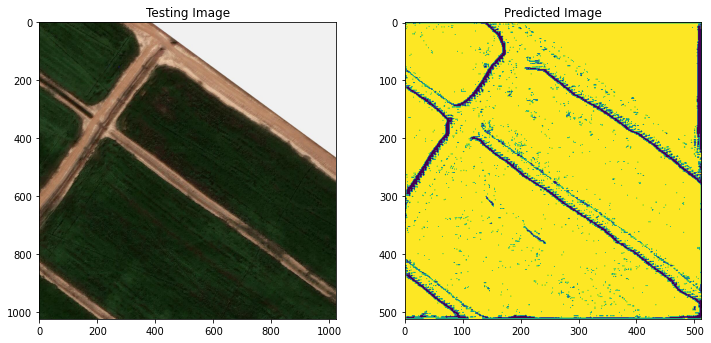

[[1 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 0 ... 0 1 1]
 [1 1 1 ... 1 1 1]]


In [15]:
from skimage import io, color
from datetime import datetime

# predictions_smooth_gray = color.rgb2gray(out)
# image_input = np.array(image_input)
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title("Testing Image")
image = Image.open(image_input)
plt.imshow(image)

plt.subplot(222)
plt.title("Predicted Image")
plt.imshow(out)
now = datetime.now()  # current date and time
time = now.strftime("%m%d%Y_%H%M")
plt.show()
print(out)


In [16]:
image_input="/content/drive/My Drive/mobilenet/testdata/images/tile_37888-2048.png"
output="/content/drive/My Drive/mobilenet/outputs/tile_37888-2048.png"

out = predict(model=None, inp=image_input, out_fname=output,
          checkpoints_path="/content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet")

/content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet.00015
loaded weights  /content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet.00015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  after removing the cwd from sys.path.


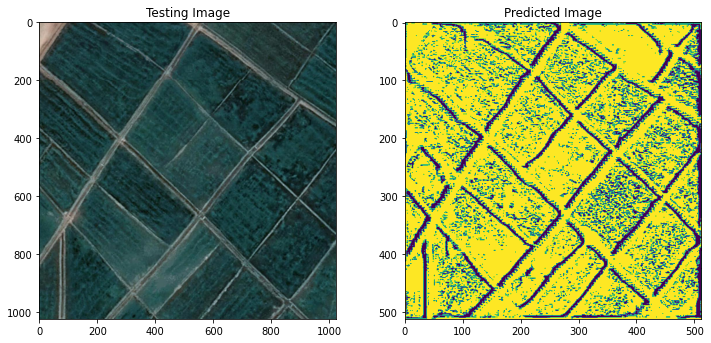

In [17]:
from skimage import io, color
from datetime import datetime

# predictions_smooth_gray = color.rgb2gray(out)
# image_input = np.array(image_input)
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title("Testing Image")
image = Image.open(image_input)
plt.imshow(image)

plt.subplot(222)
plt.title("Predicted Image")
plt.imshow(out)
now = datetime.now()  # current date and time
time = now.strftime("%m%d%Y_%H%M")
plt.show()

In [18]:
image_input="/content/drive/My Drive/mobilenet/testdata/images/tile_33792-7168.png"
output="/content/drive/My Drive/mobilenet/outputs/tile_33792-7168.png"

out = predict(model=None, inp=image_input, out_fname=output,
          checkpoints_path="/content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet")

/content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet.00015
loaded weights  /content/drive/My Drive/mobilenet/checkpoints/mobilenet_unet.00015


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  """


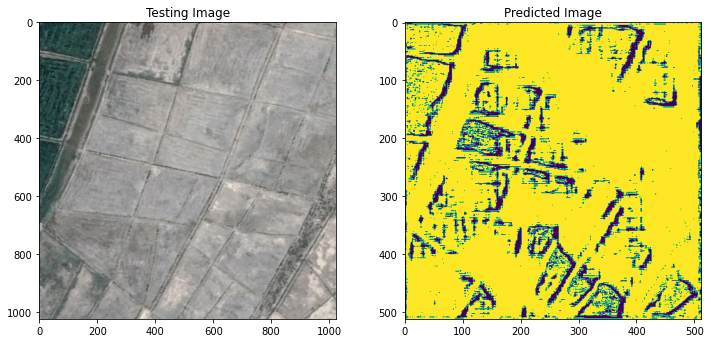

In [19]:
from skimage import io, color
from datetime import datetime


# predictions_smooth_gray = color.rgb2gray(out)
# image_input = np.array(image_input)
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title("Testing Image")
image = Image.open(image_input)
plt.imshow(image)

plt.subplot(222)
plt.title("Predicted Image")
plt.imshow(out)
now = datetime.now()  # current date and time
time = now.strftime("%m%d%Y_%H%M")
plt.show()